<ipython-input-1-e0650ba0d489>:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


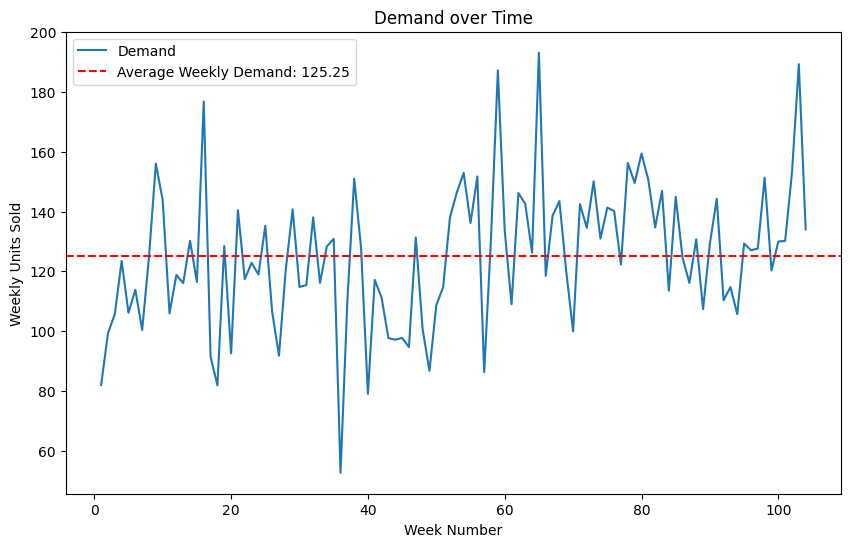

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('dataset_with_trend_seasonality.csv')

# Calculate the average value of the units sold
average_value = data['Value'].mean()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Week'], data['Value'], label='Demand')

# Add a horizontal line for the average value
plt.axhline(y=average_value, color='red', linestyle='--', label=f'Average Weekly Demand: {average_value:.2f}')

# Add labels and title
plt.title('Demand over Time')
plt.xlabel('Week Number')
plt.ylabel('Weekly Units Sold')

# Show the legend
plt.legend()

# Display the plot
plt.show()



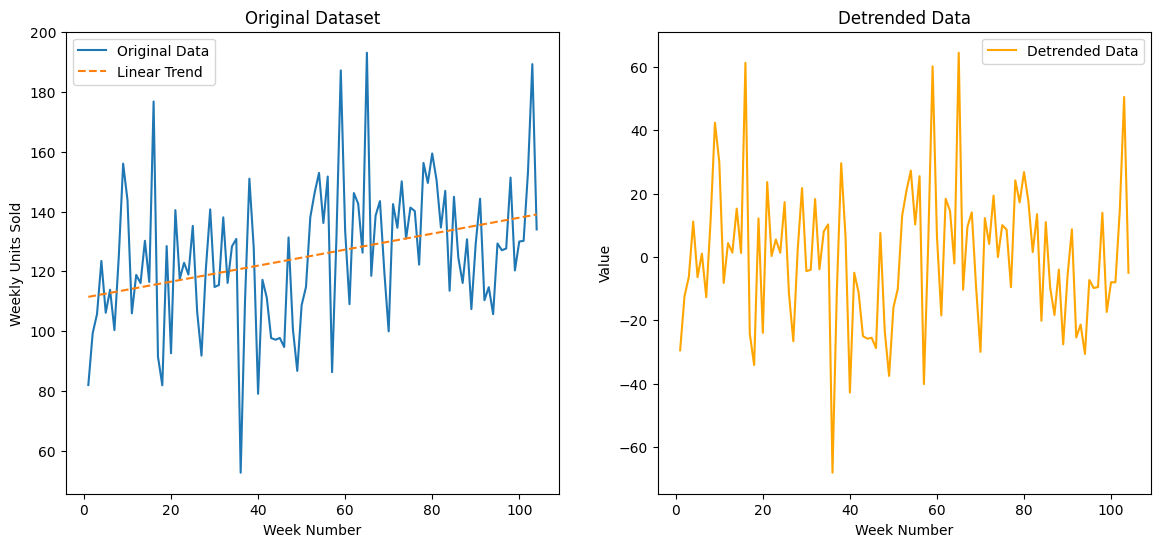

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

time = data['Week']
value = data['Value']
slope, intercept, r_value, p_value, std_err = linregress(time, value)
trend = slope * time + intercept

# Remove the trend from the data (detrend)
detrended_value = value - trend

# Plot the original data and the trend
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(time, value, label='Original Data')
plt.plot(time, trend, label='Linear Trend', linestyle='--')
plt.title('Original Dataset')
plt.xlabel('Week Number')
plt.ylabel('Weekly Units Sold')
plt.legend()

# Plot the detrended data
plt.subplot(1, 2, 2)
plt.plot(time, detrended_value, label='Detrended Data', color='orange')
plt.title('Detrended Data')
plt.xlabel('Week Number')
plt.ylabel('Value')
plt.legend()

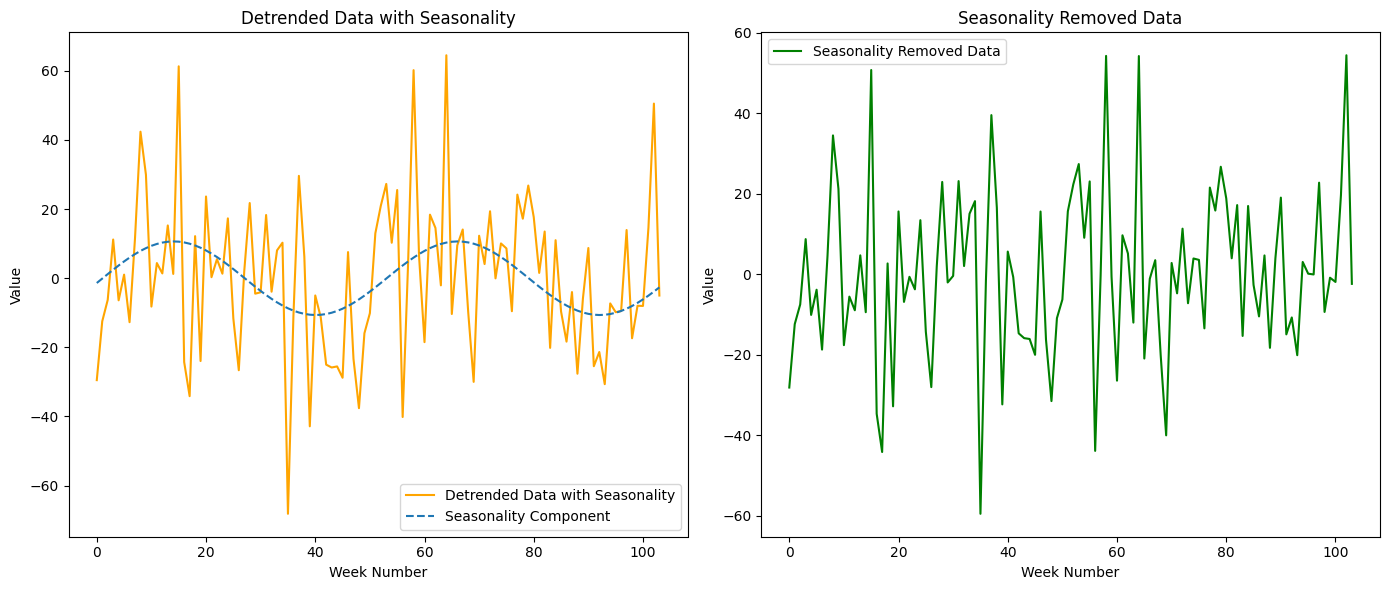

In [3]:
# Fourier expansion to remove annual seasonality
# Assuming 'Time' is in units where 1 corresponds to a week
import numpy as np
time = np.arange(104)
omega = 2 * np.pi / 52 # Fundamental frequency for annual seasonality
cos_term = np.cos(omega * time)
sin_term = np.sin(omega * time)

# Fit Fourier series terms to detrended data
X = np.column_stack((np.ones(len(time)), cos_term, sin_term))
coeffs = np.linalg.lstsq(X, detrended_value, rcond=None)[0]
seasonality = X @ coeffs

# Remove seasonality from the detrended data
seasonality_removed = detrended_value - seasonality

# Plot the detrended data before and after seasonality removal
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(time, detrended_value, label='Detrended Data with Seasonality', color='orange')
plt.plot(time, seasonality, label='Seasonality Component', linestyle='--')
plt.title('Detrended Data with Seasonality')
plt.xlabel('Week Number')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time, seasonality_removed, label='Seasonality Removed Data', color='green')
plt.title('Seasonality Removed Data')
plt.xlabel('Week Number')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


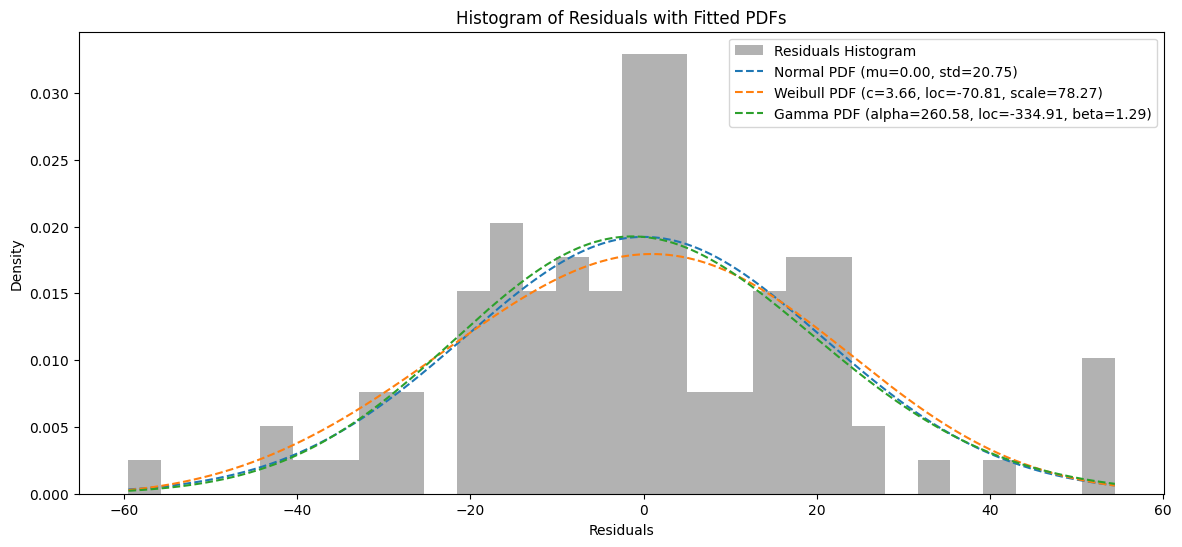

In [4]:
from scipy.stats import linregress, norm, weibull_min, gamma
# Analyze residuals
residuals = seasonality_removed

# Plot histogram of residuals
plt.figure(figsize=(14, 6))
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='gray', label='Residuals Histogram')

# Fit and plot PDFs
x = np.linspace(min(residuals), max(residuals), 1000)

# Normal distribution
mu, std = norm.fit(residuals)
pdf_norm = norm.pdf(x, mu, std)
plt.plot(x, pdf_norm, label=f'Normal PDF (mu={mu:.2f}, std={std:.2f})', linestyle='--')

# Weibull distribution
c, loc, scale = weibull_min.fit(residuals)
pdf_weibull = weibull_min.pdf(x, c, loc, scale)
plt.plot(x, pdf_weibull, label=f'Weibull PDF (c={c:.2f}, loc={loc:.2f}, scale={scale:.2f})', linestyle='--')

# Gamma distribution
alpha, loc, beta = gamma.fit(residuals)
pdf_gamma = gamma.pdf(x, alpha, loc, beta)
plt.plot(x, pdf_gamma, label=f'Gamma PDF (alpha={alpha:.2f}, loc={loc:.2f}, beta={beta:.2f})', linestyle='--')

# Add legend and labels
plt.title('Histogram of Residuals with Fitted PDFs')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()

# Determine the best fit using log-likelihood
log_likelihoods = {
    'Normal': np.sum(norm.logpdf(residuals, mu, std)),
    'Weibull': np.sum(weibull_min.logpdf(residuals, c, loc, scale)),
    'Gamma': np.sum(gamma.logpdf(residuals, alpha, loc, beta))
}

best_fit = max(log_likelihoods, key=log_likelihoods.get)


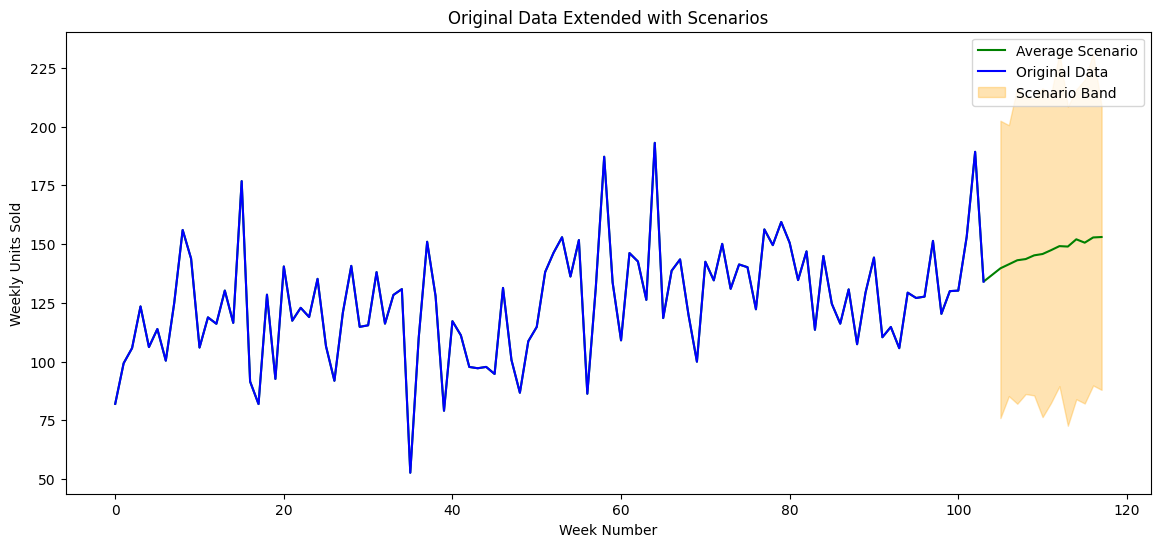

In [5]:
# Generate 100 scenarios with 5 samples each based on the best-fit distribution
num_scenarios = 1000
sample_length = 13

if best_fit == 'Normal':
    scenarios = norm.rvs(mu, std, size=(num_scenarios, sample_length))
elif best_fit == 'Weibull':
    scenarios = weibull_min.rvs(c, loc, scale, size=(num_scenarios, sample_length))
elif best_fit == 'Gamma':
    scenarios = gamma.rvs(alpha, loc, beta, size=(num_scenarios, sample_length))

# Add trend and seasonality back to the scenarios
last_time = data['Week'].iloc[-1]
scenario_time = np.arange(last_time + 1, last_time + 1 + sample_length)
trend_scenarios = slope * scenario_time + intercept
cos_term_scenarios = np.cos(omega * scenario_time)
sin_term_scenarios = np.sin(omega * scenario_time)
seasonality_scenarios = coeffs[0] + coeffs[1] * cos_term_scenarios + coeffs[2] * sin_term_scenarios

final_scenarios = scenarios + trend_scenarios + seasonality_scenarios

# Compute the average of the scenarios
average_scenario = np.mean(final_scenarios, axis=0)

# Plot the original data extended with the average scenario and scenario bands
plt.figure(figsize=(14, 6))

plt.plot(np.concatenate([time, scenario_time]),
         np.concatenate([value, average_scenario]), label='Average Scenario', color='green')
plt.plot(time, value, label='Original Data', color='blue')
# Add scenario bands
lower_bound = np.min(final_scenarios, axis=0)
upper_bound = np.max(final_scenarios, axis=0)
plt.fill_between(scenario_time, lower_bound, upper_bound, color='orange', alpha=0.3, label='Scenario Band')

plt.title('Original Data Extended with Scenarios')
plt.xlabel('Week Number')
plt.ylabel('Weekly Units Sold')
plt.legend()
plt.show()

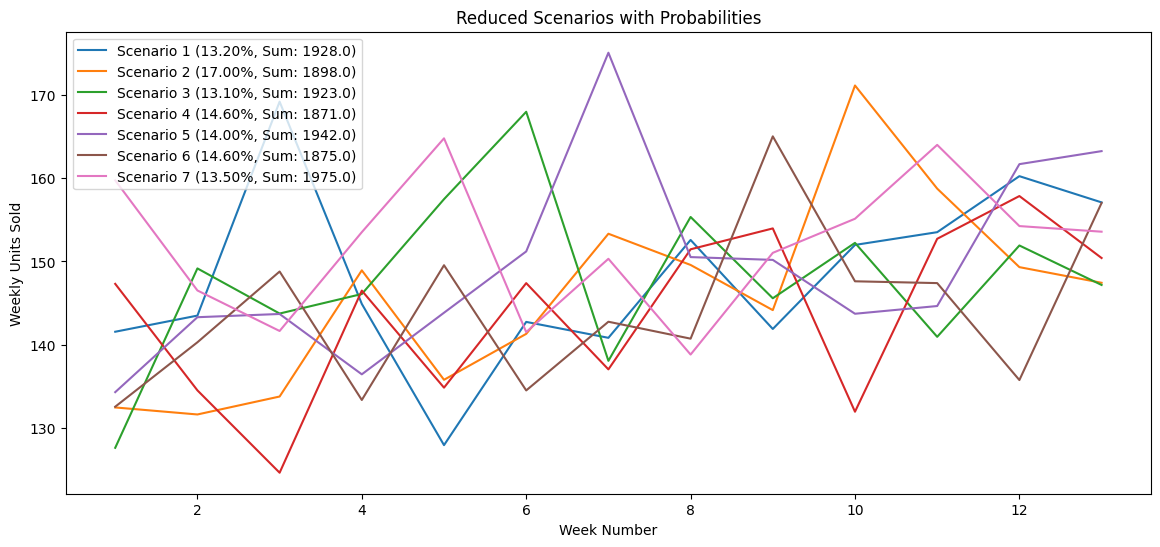

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


num_clusters = 7  # Reduce to 7 scenarios

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(final_scenarios)

# Get the cluster centers (representative scenarios)
reduced_scenarios = kmeans.cluster_centers_

# Calculate the probability of occurrence for each scenario
labels, counts = np.unique(kmeans.labels_, return_counts=True)
probabilities = counts / len(final_scenarios)

# Plot the reduced scenarios
scenario_time = np.arange(1, reduced_scenarios.shape[1] + 1)
plt.figure(figsize=(14, 6))

for i, (scenario, prob) in enumerate(zip(reduced_scenarios, probabilities)):
    # Calculate and round the sum of each scenario
    scenario_sum = np.sum(scenario)
    rounded_sum = round(scenario_sum, 0)
    
    # Include the rounded sum in the legend
    plt.plot(scenario_time, scenario, label=f'Scenario {i+1} ({probabilities[i]:.2%}, Sum: {rounded_sum})')

plt.title('Reduced Scenarios with Probabilities')
plt.xlabel('Week Number')
plt.ylabel('Weekly Units Sold')
plt.legend()
plt.show()
